In [1]:
import logging
import os
import sys
import shutil
import tempfile
import pandas as pd

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.networks.nets import resnet18
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.2.0
Numpy version: 1.26.0
Pytorch version: 2.1.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /root/miniconda3/envs/cmri/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.19.3
Pillow version: 10.0.1
Tensorboard version: 2.12.1
gdown version: 4.7.1
TorchVision version: 0.16.0
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.1.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-rec

In [2]:
df = pd.read_csv('Snapshot_tidy_brain.csv')
df

,patients,"Sex (1=M, 2=F)",Age (years),SDMT,images
0,9001,2,35,35,/home/yw4196/Snapshot_brain_nii/9001_brain.nii.gz
1,9003,2,53,56,/home/yw4196/Snapshot_brain_nii/9003_brain.nii.gz
2,9004,2,52,54,/home/yw4196/Snapshot_brain_nii/9004_brain.nii.gz
3,9005,1,37,31,/home/yw4196/Snapshot_brain_nii/9005_brain.nii.gz
4,9006,2,39,38,/home/yw4196/Snapshot_brain_nii/9006_brain.nii.gz
5,9007,2,54,50,/home/yw4196/Snapshot_brain_nii/9007_brain.nii.gz
6,9008,2,48,52,/home/yw4196/Snapshot_brain_nii/9008_brain.nii.gz
7,9009,2,50,23,/home/yw4196/Snapshot_brain_nii/9009_brain.nii.gz
8,9016,2,54,69,/home/yw4196/Snapshot_brain_nii/9016_brain.nii.gz
9,9018,2,56,62,/home/yw4196/Snapshot_brain_nii/9018_brain.nii.gz


In [3]:
images = df["images"].tolist()
labels = df["SDMT"].tolist()

In [4]:
train_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(),Resize((128, 128, 128)), RandRotate90()])

val_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((128, 128, 128))])

check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms)

check_loader = DataLoader(check_ds, batch_size=2, num_workers = 0, pin_memory=pin_memory)
im, label = monai.utils.misc.first(check_loader)
print(type(im), im.shape, label, label.shape)

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([2, 1, 128, 128, 128]) tensor([35, 56]) torch.Size([2])


In [5]:
train_ds = ImageDataset(image_files=images[:30], labels=labels[:30] , transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, num_workers =0, shuffle=True, pin_memory=pin_memory)

# create a validation data loader
val_ds = ImageDataset(image_files=images[-12:], labels=labels[-12:] , transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, pin_memory=pin_memory)


<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([2, 1, 128, 128, 128]) tensor([43, 45]) torch.Size([2])


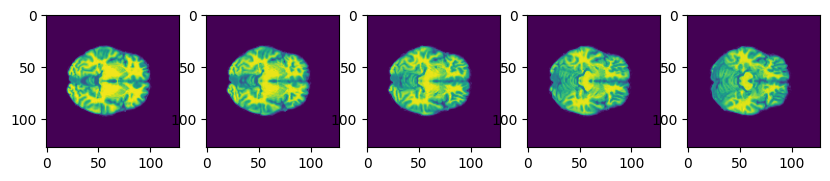

In [6]:
im, label = monai.utils.misc.first(train_loader)
print(type(im), im.shape, label, label.shape)
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(im[0, 0,:,59 + i])
    plt.gcf().set_size_inches(10, 10)
plt.show()

In [7]:
#from monai import model_constructor
net = resnet18(
    pretrained=False,
    spatial_dims=3,
    n_input_channels=1,
    num_classes=1  # Change the number of output classes to 1 for regression
)
net_dict = net.state_dict()
pretrain = torch.load("resnet_18_23dataset.pth")
pretrain['state_dict'] = {k.replace('module.', ''): v for k, v in pretrain['state_dict'].items()}
# #missing = tuple({k for k in net_dict.keys() if k not in pretrain['state_dict']})
# #logging.debug(f"missing in pretrained: {len(missing)}")
# #inside = tuple({k for k in pretrain['state_dict'] if k in net_dict.keys()})
# #logging.debug(f"inside pretrained: {len(inside)}")
# #unused = tuple({k for k in pretrain['state_dict'] if k not in net_dict.keys()})
# #logging.debug(f"unused pretrained: {len(unused)}")
# assert len(inside) > len(missing)
# assert len(inside) > len(unused)

pretrain['state_dict'] = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
net.load_state_dict(pretrain['state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['layer2.0.downsample.0.weight', 'layer2.0.downsample.0.bias', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.0.downsample.1.running_mean', 'layer2.0.downsample.1.running_var', 'layer3.0.downsample.0.weight', 'layer3.0.downsample.0.bias', 'layer3.0.downsample.1.weight', 'layer3.0.downsample.1.bias', 'layer3.0.downsample.1.running_mean', 'layer3.0.downsample.1.running_var', 'layer4.0.downsample.0.weight', 'layer4.0.downsample.0.bias', 'layer4.0.downsample.1.weight', 'layer4.0.downsample.1.bias', 'layer4.0.downsample.1.running_mean', 'layer4.0.downsample.1.running_var', 'fc.weight', 'fc.bias'], unexpected_keys=[])

In [9]:
#model = net.to(device)
from monai.networks.nets import Regressor

model = Regressor(in_shape=[1, 128, 128, 128], out_shape=1, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)
model = model.to(device)
# loss_function = torch.nn.MSELoss()
loss_function = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
loss_val = 0
#writer = SummaryWriter()
max_epochs = 2

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = torch.squeeze(model(inputs), 1)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        #writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()

#         num_correct = 0.0
#         metric_count = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            with torch.no_grad():
                val_outputs = torch.squeeze(model(val_images), 1)
                value = abs(val_outputs.cpu().numpy()-val_labels.cpu().numpy())
                loss_val += np.sum(value)
        metric = loss_val / len(val_ds)
        print(f"val_loss: {metric:.4f}")

#         metric = num_correct / metric_count
#         metric_values.append(metric)

#         if metric > best_metric:
#             best_metric = metric
#             best_metric_epoch = epoch + 1
#             torch.save(model.state_dict(), "best_metric_model_classification3d_array.pth")
#             print("saved new best metric model")

#         print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f} ")
#         print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
#         writer.add_scalar("val_accuracy", metric, epoch + 1)

# print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
# writer.close()

----------
epoch 1/2
1/15, train_loss: 49.4712
2/15, train_loss: 31.4657
3/15, train_loss: 39.4490
4/15, train_loss: 32.2228
5/15, train_loss: 25.8952
6/15, train_loss: 33.1670
7/15, train_loss: 11.5911
8/15, train_loss: 13.5975
9/15, train_loss: 27.0239
10/15, train_loss: 9.0282
11/15, train_loss: 5.0458
12/15, train_loss: 28.2750
13/15, train_loss: 13.0055
14/15, train_loss: 14.5619
15/15, train_loss: 2.9510
epoch 1 average loss: 22.4500
----------
epoch 2/2
1/15, train_loss: 40.4655
2/15, train_loss: 14.8087
3/15, train_loss: 20.6339
4/15, train_loss: 5.6379
5/15, train_loss: 13.3322
6/15, train_loss: 4.2319
7/15, train_loss: 16.0718
8/15, train_loss: 20.0023
9/15, train_loss: 12.8820
10/15, train_loss: 29.1954
11/15, train_loss: 5.4423
12/15, train_loss: 8.2249
13/15, train_loss: 12.6781
14/15, train_loss: 7.9316
15/15, train_loss: 18.9381
epoch 2 average loss: 15.3651
val_loss: 12.0496


In [9]:
torch.save(model.state_dict(), "reg_MONAI_Snapshot_brain.pth")

In [10]:
# create a validation data loader
test_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [28]:
# Get a random image and its corresponding label
img, label = get_next_im()


In [31]:
rescpu = res[0].cpu().numpy()
unique_elements, counts = np.unique(rescpu, return_counts=True)

print("Unique elements:", unique_elements)
print("Counts:", counts)

Unique elements: [1.]
Counts: [2097152]


In [52]:
img.shape

torch.Size([1, 1, 128, 128, 128])

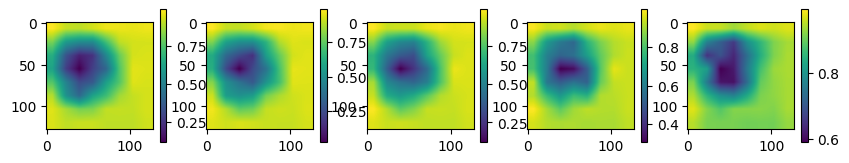

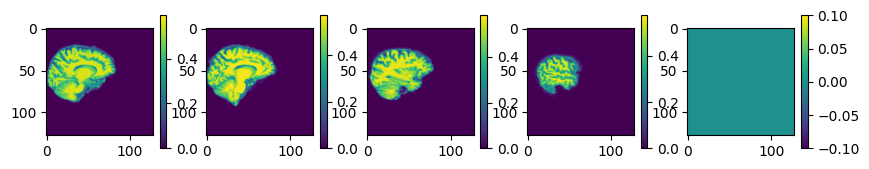

In [100]:
from monai.visualize import GradCAMpp
cam = GradCAMpp(nn_module=model, target_layers="net.layer_3")
result = cam(x=img)
a = 0
b = 0
d = 59

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(result[a, b, d + i, :].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()

for i in range(0, 50, 10):  # start at 0, stop at 50, step by 10
    plt.subplot(5, 5, i // 10 + 1)
    im = plt.imshow(img[a, b, d + i, :].cpu().numpy())
    plt.colorbar(im)  # Add a colorbar for each image
    plt.gcf().set_size_inches(10, 10)
plt.show()